In [1]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
import sys
sys.path.append("../")
sys.path.append("../../")
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True, local_files_only = False)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [2]:
from gpt2_batch.gpt2_probabilistic_model_wrapper_batch import GPT2_probabilistic_model_wrapper_batch
from floating_point_wfa_01 import alphabet

wrapper = GPT2_probabilistic_model_wrapper_batch(50, alphabet, device, model, tokenizer)

In [3]:
from floating_point_wfa_01 import get_floating_point_wfa_01
from pythautomata.utilities.guiding_wfa_sequence_generator import GuidingWDFASequenceGenerator
guiding_wfa = get_floating_point_wfa_01(wrapper.terminal_symbol)
guiding_generator = GuidingWDFASequenceGenerator(guiding_wfa, None)
guiding_generator.generate_words(10)

[ϵ, .,3,7,8, ., ., .,0,6,0,8,1,5, ., ., .,2,7,3, ϵ, .]

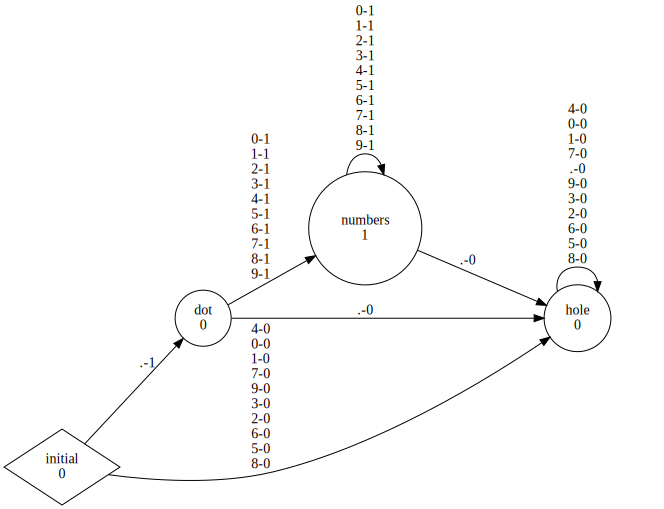

In [4]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(guiding_wfa)

display(graph)

In [5]:
from src_batch.synchronic_model_guided_language_model_batch import SynchronicModelGuidedLanguageModelBatch

property_model = get_floating_point_wfa_01(wrapper.terminal_symbol)
synchronic_model = SynchronicModelGuidedLanguageModelBatch(wrapper, property_model, 
                                                      model_name="GUIDED_GPT2", 
                                                      max_seq_length=100,
                                                      normalize_outputs=True)

In [7]:
from src_batch.hypothesis_aware_sample_probabilistic_teacher_batch import HypothesisAwareSampleProbabilisticTeacherBatch
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitionerPlus, RankingPartitioner

In [8]:
def export_pdfa_to_prism(pdfa, filename="model.prism", generate_labels=False):
    """
    Generates a .prism file from a PDFA object, handling both explicit absorbing states
    and cases where termination probabilities are less than 1. Adds label variables for transitions if specified.
    Adds a special 'final' variable for absorbing states.
    
    Parameters:
        pdfa: The PDFA object from which to extract information.
        filename: The name of the file where the PRISM model will be saved.
        generate_labels: If True, adds a boolean variable for each symbol used in non-deterministic transitions.
    """
    from collections import deque

    # Extract states and symbols (without sorting)
    states = list(pdfa.weighted_states)
    symbols = sorted(pdfa.alphabet.symbols, key=lambda symbol: str(symbol))

    # Filter states: exclude only HOLE
    states_to_include = [state for state in states if state.name != "HOLE"]

    # Detect the initial state
    initial_state = next((state for state in states_to_include if state.initial_weight == 1.0), None)
    if initial_state is None:
        raise ValueError("No initial state with initial_weight = 1.0 found.")

    # Perform DFS to determine a natural order of states
    visited = set()
    ordered_states = []
    used_symbols = set()  # Track only used symbols in non-deterministic transitions

    def dfs(state):
        if state in visited or state.name == "HOLE":
            return
        visited.add(state)
        ordered_states.append(state)
        for symbol in symbols:
            symbol_transitions = state.transitions_list.get(symbol, [])
            for next_state, weight in symbol_transitions:
                if weight > 0:
                    if weight < 1.0:
                        used_symbols.add(symbol)
                    dfs(next_state)

    dfs(initial_state)

    # Add any unvisited states (if they exist)
    for state in states_to_include:
        if state not in visited:
            ordered_states.append(state)

    # Check if any state has a termination probability > 0
    has_termination_probabilities = any(state.final_weight > 0 for state in ordered_states)

    # Check for explicit absorbing state
    absorbing_state = next((state for state in ordered_states if state.final_weight == 1), None)

    # Handle absorbing state logic
    has_implicit_absorbing = absorbing_state is None and has_termination_probabilities
    if has_implicit_absorbing:
        absorbing_state_index = len(ordered_states)
    elif absorbing_state:
        absorbing_state_index = ordered_states.index(absorbing_state)
    else:
        absorbing_state_index = None

    # Map states to new indices
    state_to_index = {state: i for i, state in enumerate(ordered_states)}
    initial_state_index = state_to_index[initial_state]

    # Generate transitions
    transitions = []
    for i, state in enumerate(ordered_states):
        if absorbing_state and state == absorbing_state:
            continue

        state_transitions = []
        total_transition_weight = 0.0

        # Regular transitions (symbols)
        for symbol in symbols:
            symbol_transitions = state.transitions_list.get(symbol, [])
            for next_state, weight in symbol_transitions:
                if weight > 0 and next_state.name != "HOLE" and next_state in ordered_states:
                    next_state_index = state_to_index[next_state]
                    # Add labels only for non-deterministic transitions
                    if generate_labels and symbol in used_symbols and weight < 1.0:
                        state_transitions.append(
                            f"{weight} : (s'={next_state_index}) & (label_{symbol}' = true)"
                        )
                    else:
                        state_transitions.append(f"{weight} : (s'={next_state_index})")
                    total_transition_weight += weight

        # Termination transition (final probability)
        final_weight = state.final_weight
        if final_weight > 0:
            if has_implicit_absorbing:
                state_transitions.append(f"{final_weight} : (s'={absorbing_state_index})")
            else:
                state_transitions.append(f"{final_weight} : (s'={state_to_index[absorbing_state]})")
            total_transition_weight += final_weight

        

        # Add valid transitions
        if state_transitions:
            transitions.append(f"    [] s={i} -> {' + '.join(state_transitions)};")

    # Add absorbing state transition and activate final variable
    if has_implicit_absorbing:
        transitions.append(
            f"    [] s={absorbing_state_index} -> 1.0 : (s'={absorbing_state_index}) & (final' = true);  // Absorbing state"
        )
    elif absorbing_state:
        transitions.append(
            f"    [] s={state_to_index[absorbing_state]} -> 1.0 : (s'={state_to_index[absorbing_state]}) & (final' = true);  // Absorbing state"
        )

    # Write PRISM model
    with open(filename, "w") as file:
        file.write("// Automatically generated PRISM file from PDFA\n")
        file.write("dtmc\n\n")
        file.write("module pdfa_model\n")

        # Define initial state and state space
        state_space_size = len(ordered_states) if not has_implicit_absorbing else len(ordered_states) + 1
        file.write(f"    s : [0..{state_space_size - 1}] init 0;\n\n")

        # Generate boolean labels for symbols and absorbing state
        if generate_labels:
            for symbol in used_symbols:
                file.write(f"    label_{symbol} : bool init false;\n")
        # Add the absorbing state variable
        file.write(f"    final : bool init false;\n\n")

        # Write transitions
        for transition in transitions:
            file.write(f"{transition}\n")

        file.write("endmodule\n")

    print(f"PRISM file successfully generated: {filename}")


In [9]:
from src_batch.bounded_pdfa_quantization_n_ary_tree_learner_batch import BoundedPDFAQuantizationNAryTreeLearnerBatch

In [12]:
import itertools
import time
from datetime import datetime
import csv
import os
from pyinstrument import Profiler


# Definir los valores a probar para cada parámetro
quantization_values = [5]
max_states_list = [250]
max_query_lengths = [25]
max_seq_lengths = [20]
sample_sizes = [100]

# Obtener la fecha actual para crear las carpetas
actual_date = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")

# Crear las carpetas con la fecha actual
pdfa_folder = os.path.join("./1_extracted_pdfas_batch", actual_date)
dtmc_folder = os.path.join("./2_extracted_dtmcs_batch", actual_date)
results_folder = os.path.join("./3_results_batch", actual_date)

# Asegurarse de que las carpetas existan
os.makedirs(pdfa_folder, exist_ok=True)
os.makedirs(dtmc_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

# Generar todas las combinaciones posibles
param_combinations = list(itertools.product(
    quantization_values, max_states_list, max_query_lengths, max_seq_lengths, sample_sizes
))

# Crear el archivo CSV para guardar los resultados
csv_file = os.path.join(results_folder, "results.csv")  # results.csv dentro de la carpeta con la fecha
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    # Escribir la cabecera del CSV
    writer.writerow([
        "quantization_value", "max_states", "max_query_length", "max_seq_length", "sample_size",
        "execution_time", "equivalence_queries_count", "last_token_weight_queries_count",
        "NumberOfStatesExceeded", "QueryLengthExceeded", "TimeExceeded"
    ])

    # Iterar sobre cada combinación de parámetros
    for combo in param_combinations:
        quantization_value, max_states, max_query_length, max_seq_length, sample_size = combo

        # Crear el partitioner, comparator, teacher y learner con los valores actuales
        partitioner = QuantizationProbabilityPartitionerPlus(quantization_value)
        comparator = WFAPartitionComparator(partitioner)
        teacher = HypothesisAwareSampleProbabilisticTeacherBatch(
            synchronic_model, comparator=comparator, max_seq_length=max_seq_length, sample_size=sample_size
        )
        learner = BoundedPDFAQuantizationNAryTreeLearnerBatch(
            partitioner=partitioner, max_states=max_states, max_query_length=max_query_length,
            max_seconds_run=None, generate_partial_hipothesis=True,
            pre_cache_queries_for_building_hipothesis=True,
            check_probabilistic_hipothesis=True,
            mean_distribution_for_partial_hipothesis=True,
            omit_zero_transitions=True
        )

        # Medir el tiempo de ejecución
        start_time = time.time()
        try:
            
            profiler = Profiler()
            profiler.start()
            learning_result = learner.learn(teacher, verbose=False)
            profiler.stop()
            
            

            execution_time = time.time() - start_time
            
            html_output = profiler.output_html()

            with open('profile_output_batch.html', 'w') as f:
                f.write(html_output)

            # Extraer la información relevante de learning_result.info
            info = learning_result.info
            results_row = [
                quantization_value, max_states, max_query_length, max_seq_length, sample_size,
                execution_time, info["equivalence_queries_count"], info["last_token_weight_queries_count"],
                info["NumberOfStatesExceeded"], info["QueryLengthExceeded"], info["TimeExceeded"]
            ]

            # Escribir la fila en el CSV
            writer.writerow(results_row)

            # Exportar el PDFA a .dot y .prism
            pdfa = learning_result.model
            params_str = f"quant_{quantization_value}_states_{max_states}_querylen_{max_query_length}_seqlen_{max_seq_length}_samplesize_{sample_size}"
            
            # Guardar el archivo .dot en la carpeta con la fecha dentro de 1_extracted_pdfas
            dot_file = os.path.join(pdfa_folder, f"{params_str}_{actual_date}.dot")
            exporter.export(pdfa, dot_file)

            # Guardar el archivo .prism en la carpeta con la fecha dentro de 2_extracted_dtmcs
            prism_file = os.path.join(dtmc_folder, f"{params_str}_{actual_date}.prism")
            export_pdfa_to_prism(pdfa, prism_file, generate_labels=True)

            print(f"✅ Combination completed: {params_str}")

        except Exception as e:
            execution_time = time.time() - start_time
            print(f"❌ Error in combination: {params_str}")
            print(f"    Error details: {str(e)}")
            # Guardar la combinación fallida en el CSV con un mensaje de error
            writer.writerow([
                quantization_value, max_states, max_query_length, max_seq_length, sample_size,
                execution_time, "ERROR", "ERROR", "ERROR", "ERROR", "ERROR"
            ])

print(f"🎉 All results have been saved in folders with the date: {actual_date}")

[BATCH DEBUG] group with suffixes=1 → 1 sequences
Wrapper Batch CALL — Batch size: 1 | Suffixes: 1
[BATCH DEBUG] group with suffixes=0 → 972 sequences
[BATCH DEBUG] group with suffixes=10 → 4 sequences
Wrapper Batch CALL — Batch size: 4 | Suffixes: 10
[BATCH DEBUG] group with suffixes=11 → 25 sequences
Wrapper Batch CALL — Batch size: 25 | Suffixes: 11
[BATCH DEBUG] group with suffixes=10 → 1 sequences
Wrapper Batch CALL — Batch size: 1 | Suffixes: 10
[BATCH DEBUG] group with suffixes=1 → 1 sequences
Wrapper Batch CALL — Batch size: 1 | Suffixes: 1
[BATCH DEBUG] group with suffixes=10 → 1 sequences
Wrapper Batch CALL — Batch size: 1 | Suffixes: 10
[BATCH DEBUG] group with suffixes=1 → 1 sequences
Wrapper Batch CALL — Batch size: 1 | Suffixes: 1
[BATCH DEBUG] group with suffixes=10 → 1 sequences
Wrapper Batch CALL — Batch size: 1 | Suffixes: 10
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=0 → 11 

[BATCH DEBUG] group with suffixes=11 → 9 sequences
Wrapper Batch CALL — Batch size: 9 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 8 sequences
Wrapper Batch CALL — Batch size: 8 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 8 sequences
Wrapper Batch CALL — Batch size: 8 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 8 sequences
Wrapper Batch CALL — Batch size: 8 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 8 sequences
Wrapper Batch CALL — Batch size: 8 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size

[BATCH DEBUG] group with suffixes=11 → 9 sequences
Wrapper Batch CALL — Batch size: 9 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 9 sequences
Wrapper Batch CALL — Batch size: 9 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 7 sequences
Wrapper Batch CALL — Batch size: 7 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 7 sequences
Wrapper Batch CALL — Batch size: 7 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 7 sequences
Wrapper Batch CALL — Batch size: 7 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 1 sequences
Wrapper Batch CALL — Batch size:

[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 5 sequences
Wrapper Batch CALL — Batch size: 5 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 5 sequences
Wrapper Batch CALL — Batch size: 5 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 5 sequences
Wrapper Batch CALL — Batch size: 5 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 5 sequences
Wrapper Batch CALL — Batch size: 5 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 9 sequences
Wrapper Batch CALL — Batch size: 9 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 9 sequences
Wrapper Batch CALL — Batch size:

[BATCH DEBUG] group with suffixes=11 → 9 sequences
Wrapper Batch CALL — Batch size: 9 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 9 sequences
Wrapper Batch CALL — Batch size: 9 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 4 sequences
Wrapper Batch CALL — Batch size: 4 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 4 sequences
Wrapper Batch CALL — Batch size: 4 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 4 sequences
Wrapper Batch CALL — Batch size: 4 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 4 sequences
Wrapper Batch CALL — Batch size: 4 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 10 sequences
Wrapper Batch CALL — Batch size: 10 | Suffixes: 11
[BATCH DEBUG] group with suffixes=11 → 4 sequences
Wrapper Batch CALL — Batch size: 4